In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
%pip install xgboost
from xgboost import XGBRegressor

Note: you may need to restart the kernel to use updated packages.


In [5]:

df = pd.read_csv('train_001.csv')
print(f"Dataset shape: {df.shape}")
df.head()

df.info()
print("\nTarget Variable Statistics:")
#

Dataset shape: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

In [6]:

missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print(f"\nFeatures with missing values: {len(missing_data)}")
print(missing_data.head(15))



Features with missing values: 19
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
dtype: int64


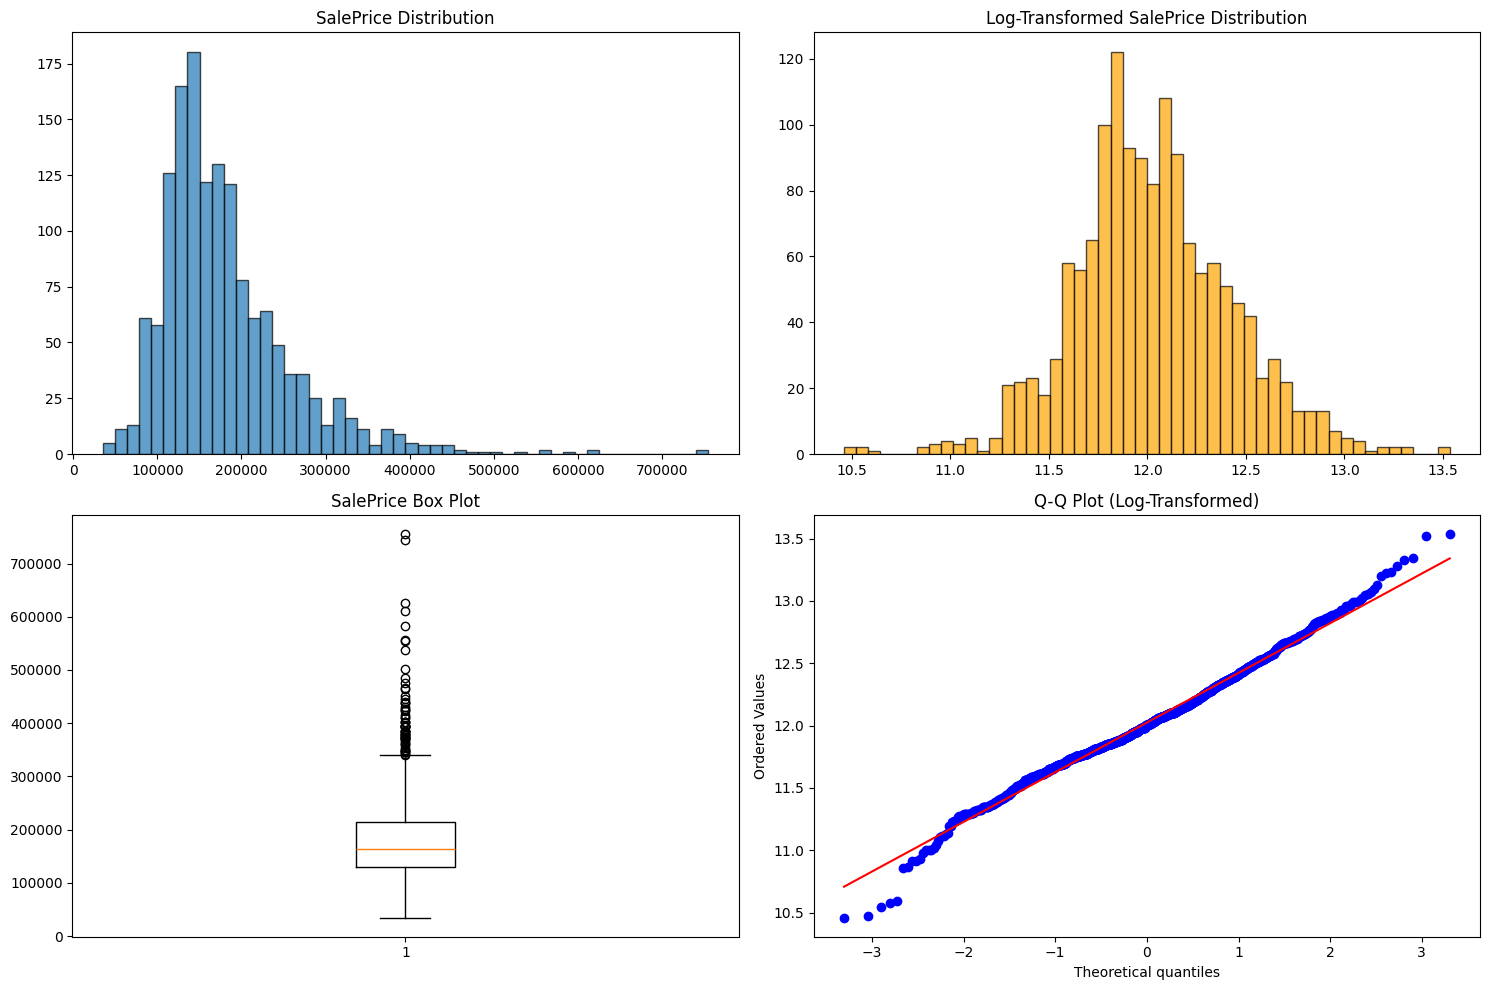

In [7]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('SalePrice Distribution')

log_prices = np.log1p(df['SalePrice'])
axes[0, 1].hist(log_prices, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Log-Transformed SalePrice Distribution')

axes[1, 0].boxplot(df['SalePrice'])
axes[1, 0].set_title('SalePrice Box Plot')

stats.probplot(log_prices, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log-Transformed)')

plt.tight_layout()
plt.show()


In [8]:
print(f"Original skewness: {skew(df['SalePrice']):.4f}")
print(f"Log-transformed skewness: {skew(log_prices):.4f}")

numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Id')

correlations = df[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
top_features = correlations.head(10)


Original skewness: 1.8809
Log-transformed skewness: 0.1212



Top Features Correlated with SalePrice:
OverallQual: 0.7910
GrLivArea: 0.7086
GarageCars: 0.6404
GarageArea: 0.6234
TotalBsmtSF: 0.6136
1stFlrSF: 0.6059
FullBath: 0.5607
TotRmsAbvGrd: 0.5337
YearBuilt: 0.5229


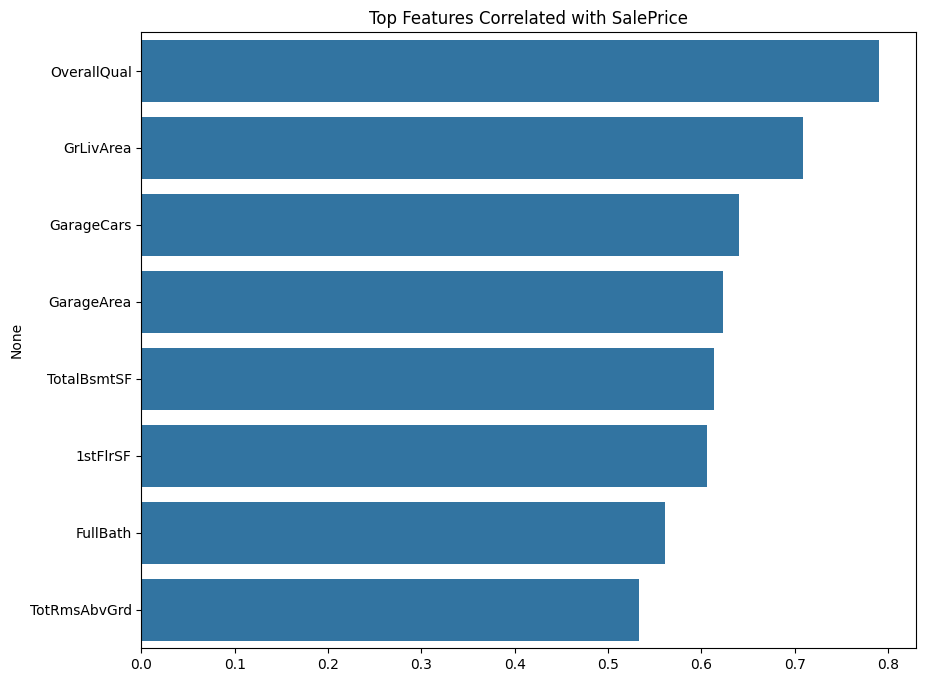

In [9]:

print("\nTop Features Correlated with SalePrice:")
for feature, corr in top_features.items():
    if feature != 'SalePrice':
        print(f"{feature}: {corr:.4f}")

plt.figure(figsize=(10, 8))
top_corr_features = top_features.drop('SalePrice').head(8)
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title('Top Features Correlated with SalePrice')
plt.show()


In [10]:

df_clean = df.copy()

df_clean['LotFrontage'].fillna(df_clean['LotFrontage'].median(), inplace=True)

for col in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
           'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
           'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
    df_clean[col].fillna('None', inplace=True)

df_clean['MasVnrArea'].fillna(0, inplace=True)

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df_clean[col].fillna(0, inplace=True)

for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df_clean[col].fillna(0, inplace=True)


In [11]:
mode_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']
for col in mode_cols:
    if col in df_clean.columns:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print("Missing values after cleaning:")
print(df_clean.isnull().sum().sum())

df_clean['TotalSF'] = df_clean['TotalBsmtSF'] + df_clean['1stFlrSF'] + df_clean['2ndFlrSF']
df_clean['TotalBathrooms'] = df_clean['FullBath'] + 0.5*df_clean['HalfBath'] + df_clean['BsmtFullBath'] + 0.5*df_clean['BsmtHalfBath']
df_clean['TotalPorchSF'] = df_clean['OpenPorchSF'] + df_clean['3SsnPorch'] + df_clean['EnclosedPorch'] + df_clean['ScreenPorch'] + df_clean['WoodDeckSF']
df_clean['HouseAge'] = df_clean['YrSold'] - df_clean['YearBuilt']
df_clean['RemodAge'] = df_clean['YrSold'] - df_clean['YearRemodAdd']
df_clean['HasGarage'] = df_clean['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_clean['HasBasement'] = df_clean['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_clean['HasFireplace'] = df_clean['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


Missing values after cleaning:
0


In [12]:



print("Feature engineering completed!")

features_to_use = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                   'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'HouseAge', 'RemodAge',
                   'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea',
                   'MSSubClass', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF',
                   'HasGarage', 'HasBasement', 'HasFireplace',
                   'MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 
                   'Exterior1st', 'Foundation', 'Heating', 'CentralAir', 'KitchenQual', 
                   'SaleType', 'SaleCondition']

X = df_clean[features_to_use]
y = np.log1p(df_clean['SalePrice'])


Feature engineering completed!


In [13]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [15]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])


In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name):
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation RMSE
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                scoring='neg_root_mean_squared_error', cv=5)
    cv_rmse = -np.mean(cv_scores)
    
    results = {
        "Model": model_name,
        "test_rmse": rmse,
        "test_r2": r2,
        "cv_rmse": cv_rmse,
        "predictions": y_pred  # <-- Added for plotting
    }
    
    return results



lr_results = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test, "Linear Regression")
rf_results = evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest")
xgb_results = evaluate_model(xgb_pipeline, X_train, X_test, y_train, y_test, "XGBoost")

results_df = pd.DataFrame([
    {'Model': 'Linear Regression', 'Test RMSE': lr_results['test_rmse'], 
     'Test R²': lr_results['test_r2'], 'CV RMSE': lr_results['cv_rmse']},
    {'Model': 'Random Forest', 'Test RMSE': rf_results['test_rmse'], 
     'Test R²': rf_results['test_r2'], 'CV RMSE': rf_results['cv_rmse']},
    {'Model': 'XGBoost', 'Test RMSE': xgb_results['test_rmse'], 
     'Test R²': xgb_results['test_r2'], 'CV RMSE': xgb_results['cv_rmse']}
])


print("\nModel Comparison Summary:")
print("=" * 50)
print(results_df.round(4))



Model Comparison Summary:
               Model  Test RMSE  Test R²  CV RMSE
0  Linear Regression     0.1317   0.8999   0.1654
1      Random Forest     0.1390   0.8885   0.1492
2            XGBoost     0.1432   0.8815   0.1491


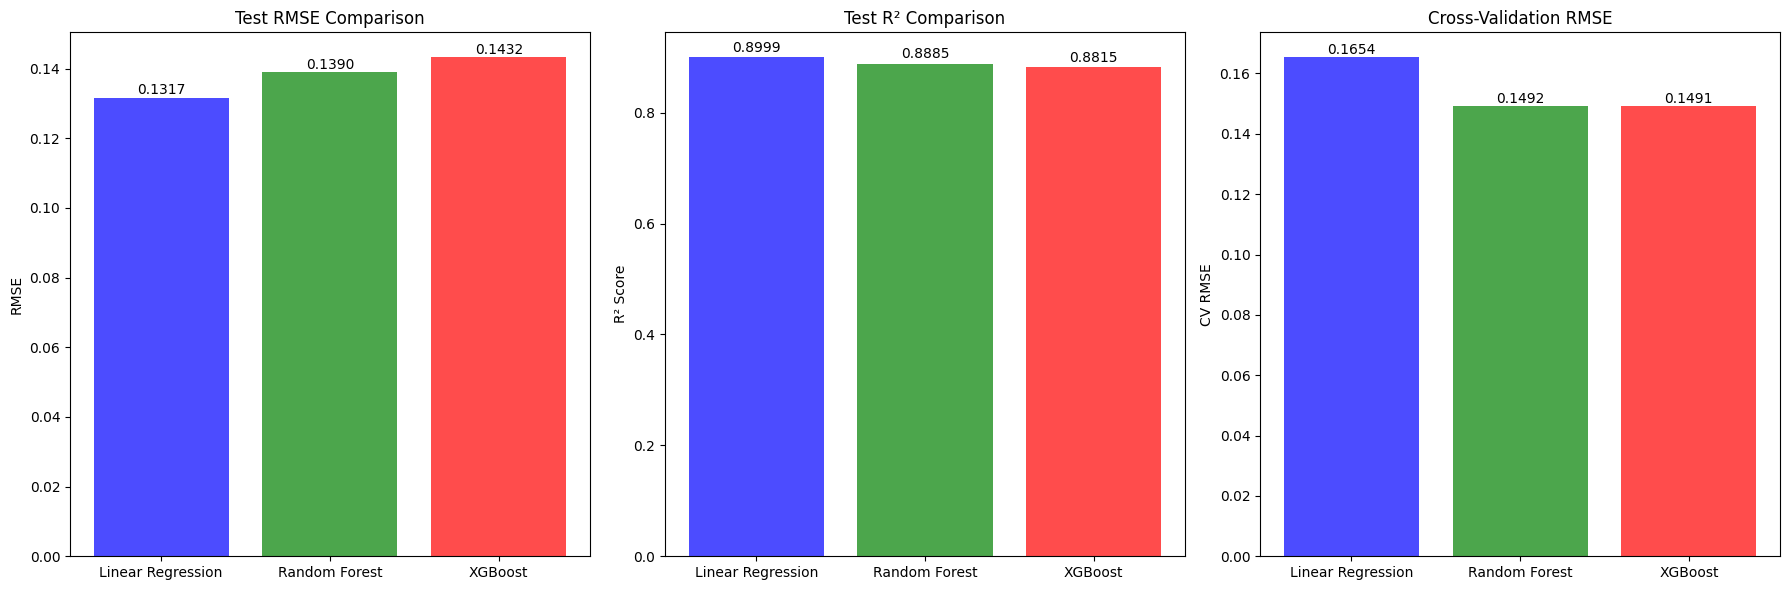

In [25]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['Linear Regression', 'Random Forest', 'XGBoost']
test_rmse = [lr_results['test_rmse'], rf_results['test_rmse'], xgb_results['test_rmse']]
test_r2 = [lr_results['test_r2'], rf_results['test_r2'], xgb_results['test_r2']]
cv_rmse = [lr_results['cv_rmse'], rf_results['cv_rmse'], xgb_results['cv_rmse']]

axes[0].bar(models, test_rmse, color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_title('Test RMSE Comparison')
axes[0].set_ylabel('RMSE')
for i, v in enumerate(test_rmse):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[1].bar(models, test_r2, color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_title('Test R² Comparison')
axes[1].set_ylabel('R² Score')
for i, v in enumerate(test_r2):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

axes[2].bar(models, cv_rmse, color=['blue', 'green', 'red'], alpha=0.7)
axes[2].set_title('Cross-Validation RMSE')
axes[2].set_ylabel('CV RMSE')
for i, v in enumerate(cv_rmse):
    axes[2].text(i, v + 0.001, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


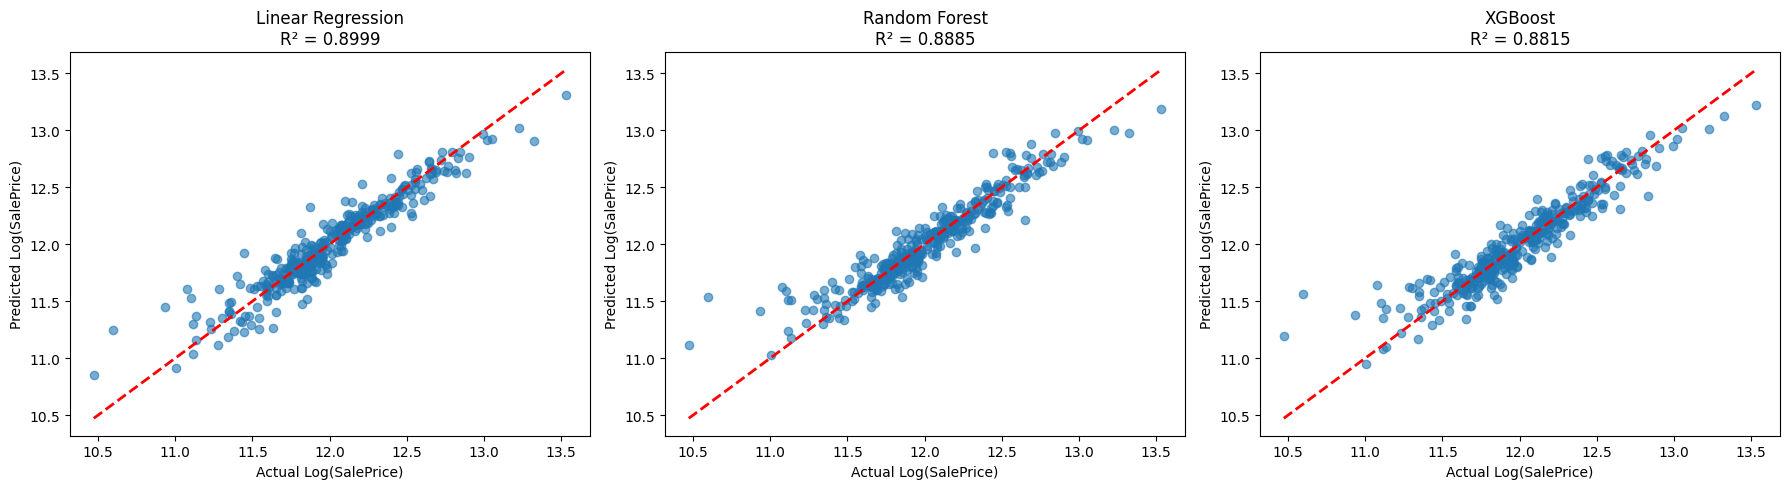

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_all = [lr_results, rf_results, xgb_results]
titles = ['Linear Regression', 'Random Forest', 'XGBoost']

for i, (res, title) in enumerate(zip(results_all, titles)):
    axes[i].scatter(y_test, res['predictions'], alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Log(SalePrice)')
    axes[i].set_ylabel('Predicted Log(SalePrice)')
    axes[i].set_title(f'{title}\nR² = {res["test_r2"]:.4f}')

plt.tight_layout()
plt.show()




Best Model Based on Cross-Validation: XGBoost
Best CV RMSE: 0.1491


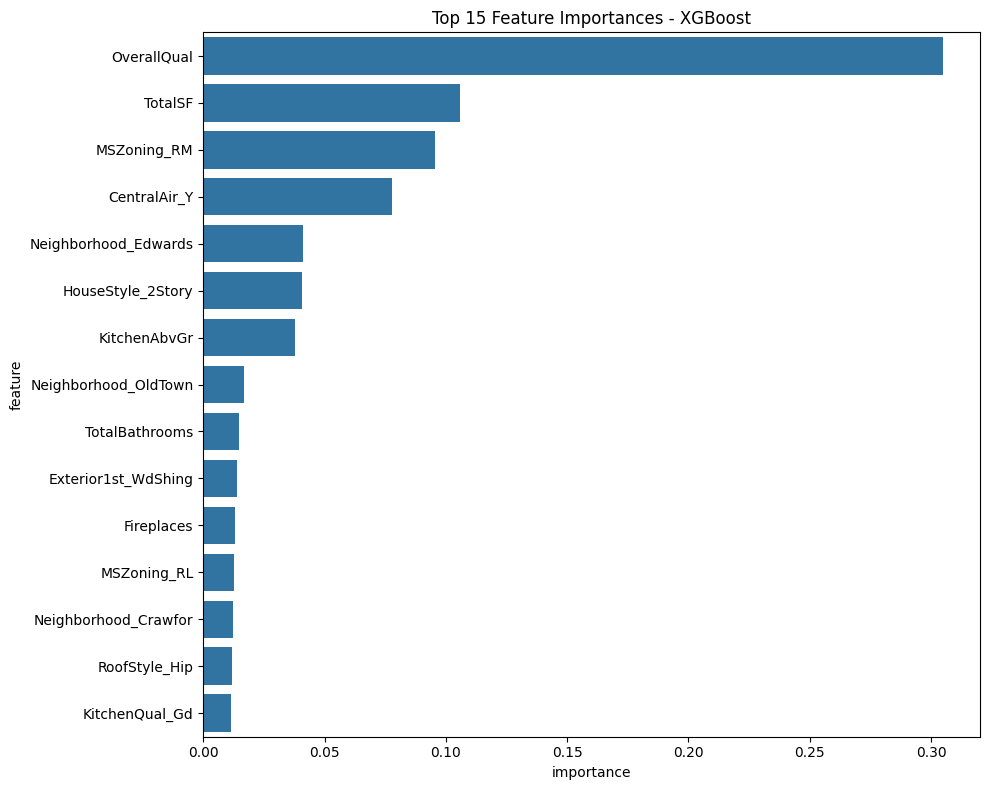


Top 10 Most Important Features (XGBoost):
                 feature  importance
1            OverallQual      0.3050
5                TotalSF      0.1057
27           MSZoning_RM      0.0956
92          CentralAir_Y      0.0780
34  Neighborhood_Edwards      0.0413
60     HouseStyle_2Story      0.0408
12          KitchenAbvGr      0.0377
44  Neighborhood_OldTown      0.0168
6         TotalBathrooms      0.0147
81   Exterior1st_WdShing      0.0139


In [27]:
best_model_idx = np.argmin([lr_results['cv_rmse'], rf_results['cv_rmse'], xgb_results['cv_rmse']])
best_models = ['Linear Regression', 'Random Forest', 'XGBoost']
best_model_name = best_models[best_model_idx]

print(f"\nBest Model Based on Cross-Validation: {best_model_name}")
print(f"Best CV RMSE: {min(cv_rmse):.4f}")

feature_names = (numeric_features + 
                list(xgb_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features)))

if best_model_name == 'XGBoost':
    importances = xgb_pipeline.named_steps['regressor'].feature_importances_
elif best_model_name == 'Random Forest':
    importances = rf_pipeline.named_steps['regressor'].feature_importances_
else:
    importances = np.abs(lr_pipeline.named_steps['regressor'].coef_)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title(f'Top 15 Feature Importances - {best_model_name}')
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features ({best_model_name}):")
print(feature_importance.head(10).round(4))